In [1]:
import copy
import gym
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from stable_baselines3 import PPO, DDPG
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy

In [2]:
class Swing(gym.Env):
    def __init__(self, target=np.pi / 2, L0=1, omega_0=-0.1):
        super(Swing, self).__init__()
        self.observation_space = gym.spaces.Box(
            low=np.array([0, -10]), high=np.array([2 * np.pi, 10])
        )
        self.action_space = gym.spaces.Box(low=np.array([-1]), high=np.array([1]))
        self.L0 = L0
        self.tau = np.sqrt(L0 / 9.8) / 4
        self.omega_0 = omega_0
        self.target = target
        self.time = 0
        self.pumps = 0
        self.phi0 = np.pi / 8
        self.phi = [self.phi0]
        self.phi_dot = [self.omega_0]
        self.L = [self.L0]
        self.L_dot = [0]
        self.full_phi_hist = [self.phi0]
        self.full_phi_dot_hist = [self.omega_0]
        self.full_L_hist = [self.L0]

    def fun(self, t, y, L, L_dot, tau=1, g=9.81):
        y0_dot = y[1]
        y1_dot = (-g / L) * np.sin(y[0]) - (2 * L_dot / L) * y[1]
        y_dot = np.hstack((y0_dot, y1_dot))
        return y_dot

    def step(self, action):
        L = action[0] + 1.1
        # L = (action[0] + 1) / 4 + 1
        self.L.append(L)
        L_dot = (L - self.L[-1]) / self.tau
        self.L_dot.append(L_dot)
        sol = si.solve_ivp(
            self.fun,
            [self.time, self.time + self.tau],
            y0=[self.phi[-1], self.phi_dot[-1]],
            args=(L, L_dot),
        )
        self.full_L_hist.extend(list([L] * sol.y[0][1:].size))
        self.full_phi_hist.extend(list(sol.y[0][1:]))
        self.full_phi_dot_hist.extend(list(sol.y[1][1:]))
        phi = np.mod(sol.y[0][-1], 2 * np.pi)
        self.phi.append(phi)
        phi_dot = sol.y[1][-1]
        self.phi_dot.append(phi_dot)
        state = np.array([phi, phi_dot])

        if np.isclose(state[0], self.target, rtol=0.05):
            reward = 10
            done = True
        elif self.pumps > 1000:
            reward = -1
            done = True
        else:
            reward = -1
            done = False
        info = {}
        self.time += self.tau
        self.pumps += 1
        return state, reward, done, info

    def reset(self):
        self.time = 0
        self.pumps = 0
        self.L = [self.L0]
        self.L_dot = [0]
        self.phi = [self.phi0]
        self.phi_dot = [self.omega_0]
        self.full_phi_dot_hist.clear()
        self.full_phi_dot_hist.append(self.omega_0)
        self.full_phi_hist.clear()
        self.full_phi_hist.append(self.phi0)
        state = np.array([self.phi[-1], self.phi_dot[-1]])
        return state

    def render(self):
        pass

In [3]:
env = Swing(target=np.pi)
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=2.5e5)

/Users/iandavenport/Desktop/research/chameleon/venv/lib/python3.7/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 81.5     |
|    ep_rew_mean     | -70.5    |
| time/              |          |
|    fps             | 1023     |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 80.2         |
|    ep_rew_mean          | -69.2        |
| time/                   |              |
|    fps                  | 892          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0016628939 |
|    clip_fraction        | 0.0042       |
|    clip_range           | 0.2          |
|    en

In [5]:
model.save("unparam_full")
del model
model = PPO.load("unparam_full.zip")

In [6]:
obs = env.reset()
done = False
i = 0
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render()
    i += 1

In [10]:
x_pos = np.array(env.L) * np.sin(env.phi)
y_pos = -np.array(env.L) * np.cos(env.phi)
ref_x = 2.1 * np.sin(env.phi)
ref_y = -2.1 * np.cos(env.phi)
pos_arr = np.vstack((x_pos, y_pos))
ref_pos_arr = np.vstack((ref_x, ref_y))
np.save("pos_arr", pos_arr)
np.save("ref_pos_arr", ref_pos_arr)

NameError: name 'times' is not defined

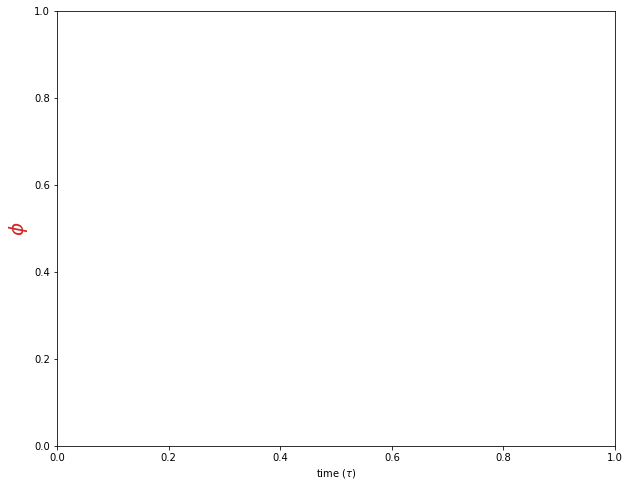

In [9]:
# fig, ax1 = plt.subplots(figsize=(10, 8))
# color = "tab:red"
# ax1.set_xlabel(r"time ($\tau$)")
# ax1.set_ylabel(r"$\phi$", color=color, fontsize=20)
# ax1.plot(times, env.phi, "-o", color=color)
# ax1.set_title("Angle and length over time", fontsize=20)

# ax2 = ax1.twinx()
# color = "tab:blue"
# ax2.set_ylabel("L", color=color, fontsize=20)
# ax2.plot(times, env.L, "-o")
# fig.tight_layout()
# plt.show()

In [ ]:
a = [1]

In [ ]:
a * 4